# Diagnóstico de Falhas em dados do simulador Tennessee Eastman

---

O código fonte relatado aqui consiste da implementação de classificadores para diagnóstico de falhas, geradas a partir do simulador Tenessee Eastman
* Disciplina : **Reconhecimento de Padrões** - PINF-6055
* Período: **2019/01**
* Aluno: **Fabio Ricardo Oliveira Bento**
* Matrícula: 2018241497



# 1) Import required libraries and auxiliary functions 

In [0]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
sns.set()

# #############################################################################
# Classification function
classifiers_names = [ "QDA", "Nearest Neighbors" ]
classifiers = [QuadraticDiscriminantAnalysis(store_covariance=True), KNeighborsClassifier(3) ]
def classify_with_stratified_kfold(clf, X, y, kf):
    y_pred_concat = [ ]
    y_test_concat = [ ]
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X=X_train, y=y_train)
        y_pred = clf.predict(X=X_test)
        y_pred_concat = np.concatenate([y_pred_concat, y_pred])
        y_test_concat = np.concatenate([y_test_concat, y_test])
    return y_pred_concat, y_test_concat


##############################################################################
# Results printing functions
def print_report(y_test, y_pred, target_names, labels):
    # Printing results
    print (classification_report(y_test, y_pred, target_names=target_names,digits=3))
    print(" Accuracy  = ",'%.2f %%' % (100*accuracy_score(y_test, y_pred)))
    print(" F-measure = ",'%.2f %%' % (100*f1_score(y_test, y_pred, average='macro')))
    print(" Precision = ",'%.2f %%' % (100*precision_score(y_true=y_test, y_pred=y_pred, average='macro')))
    print(" Recall    = ",'%.2f %%' % (100*recall_score(y_true=y_test, y_pred=y_pred, average='macro')))
    print(" Confusion matrix =\n", confusion_matrix(y_true=y_test, y_pred=y_pred,labels=labels))

# 2) Load the dataset

In [0]:
#Tennessee Eastman Simulator Attributes

XMEAS = ['Input Feed - A feed (stream 1)'	,       	#	1
    'Input Feed - D feed (stream 2)'	,       	#	2
    'Input Feed - E feed (stream 3)'	,       	#	3
    'Input Feed - A and C feed (stream 4)'	,       	#	4
    'Miscellaneous - Recycle flow (stream 8)'	,	#	5
    'Reactor feed rate (stream 6)'	,                 	#	6
    'Reactor pressure'	,                           	#	7
    'Reactor level'	,                                	#	8
    'Reactor temperature'	,                           	#	9
    'Miscellaneous - Purge rate (stream 9)'	,       	#	10
    'Separator - Product separator temperature'	,	#	11
    'Separator - Product separator level'	,       	#	12
    'Separator - Product separator pressure'	,	#	13
    'Separator - Product separator underflow (stream 10)'	,	#	14
    'Stripper level'	,                           	#	15
    'Stripper pressure'	,                           	#	16
    'Stripper underflow (stream 11)'             	,	#	17
    'Stripper temperature'	,                           	#	18
    'Stripper steam flow'	,                           	#	19
    'Miscellaneous - Compressor work'	,       	#	20
    'Miscellaneous - Reactor cooling water outlet temperature'	,	#	21
    'Miscellaneous - Separator cooling water outlet temperature'	,	#	22
    'Reactor Feed Analysis - Component A'	,	#	23
    'Reactor Feed Analysis - Component B'	,	#	24
    'Reactor Feed Analysis - Component C'	,	#	25
    'Reactor Feed Analysis - Component D'	,	#	26
    'Reactor Feed Analysis - Component E'	,	#	27
    'Reactor Feed Analysis - Component F'	,	#	28
    'Purge gas analysis - Component A'	,	#	29
    'Purge gas analysis - Component B'	,	#	30
    'Purge gas analysis - Component C'	,	#	31
    'Purge gas analysis - Component D'	,	#	32
    'Purge gas analysis - Component E'	,	#	33
    'Purge gas analysis - Component F'	,	#	34
    'Purge gas analysis - Component G'	,	#	35
    'Purge gas analysis - Component H'	,	#	36
    'Product analysis -  Component D'	,	#	37
    'Product analysis - Component E'	,	#	38
    'Product analysis - Component F'	,	#	39
    'Product analysis - Component G'	,	#	40
    'Product analysis - Component H']		#	41

XMV = ['D feed flow (stream 2)'	,                 	#	1
    'E feed flow (stream 3)'	,                 	#	2
    'A feed flow (stream 1)'	,                 	#	3
    'A and C feed flow (stream 4)'	,                 	#	4
    'Compressor recycle valve'	,                 	#	5
    'Purge valve (stream 9)'	,                 	#	6
    'Separator pot liquid flow (stream 10)'	,       	#	7
    'Stripper liquid product flow (stream 11)'	,	#	8
    'Stripper steam valve'	,                           	#	9
    'Reactor cooling water flow'	,                 	#	10
    'Condenser cooling water flow'	,                 	#	11
    'Agitator speed']             # constant 50%			12


# Load the features names
names = (XMEAS + XMV)
# Add a columns for labels (classes)
names.append("Process Faults")
# Read the dataset file
url = 'https://raw.githubusercontent.com/fabiobento/te_dataset/master/all.csv'
df = pd.read_csv(url, delimiter='\t', header=None, names=names) # Dataset is now stored in a Pandas Dataframe
#df = pd.read_csv('all.csv', delimiter='\t', header=None, names=names)
# Remove feature with same value for all the samples
df = df.drop("Agitator speed",1)
# Convert string labels to numbers
df[df.columns[-1]] = df[df.columns[-1]].map(lambda element:np.argmax(np.array(list(element[1:]))))
# Create the features amtrix and standardize data though mean removal and variance scaling
X = StandardScaler().fit_transform(df.values[:, 0: -1])
# Create the target matrix (the column with classes)
y = np.ravel(pd.DataFrame(df.iloc[:, -1]).values)
print('\t Some features and first five samples from the dataset')
df.head()

	 Some features and first five samples from the dataset


,Input Feed - A feed (stream 1),Input Feed - D feed (stream 2),Input Feed - E feed (stream 3),Input Feed - A and C feed (stream 4),Miscellaneous - Recycle flow (stream 8),Reactor feed rate (stream 6),Reactor pressure,Reactor level,Reactor temperature,Miscellaneous - Purge rate (stream 9),...,A feed flow (stream 1),A and C feed flow (stream 4),Compressor recycle valve,Purge valve (stream 9),Separator pot liquid flow (stream 10),Stripper liquid product flow (stream 11),Stripper steam valve,Reactor cooling water flow,Condenser cooling water flow,Process Faults
0,0.24692,3610.0,4443.3,9.8489,26.853,43.254,2662.9,71.272,120.32,0.33455,...,24.998,66.651,14.094,40.377,35.648,35.903,47.504,39.202,33.274,0
1,0.24692,3610.0,4443.3,10.1300,27.000,43.237,2655.3,69.850,120.27,0.33681,...,24.998,68.515,15.503,40.102,44.218,45.663,46.742,37.082,22.488,0
2,0.24696,3610.0,4443.3,10.3810,26.981,42.996,2695.0,68.720,120.43,0.33723,...,25.002,70.124,18.156,40.049,45.793,52.033,46.415,40.665,15.057,0
3,0.24696,3610.0,4443.3,10.5380,26.936,43.020,2752.3,68.195,120.52,0.33694,...,25.002,71.115,19.719,40.084,43.264,53.568,46.698,42.488,12.792,0
4,0.39983,3771.2,4602.3,10.5760,26.891,43.468,2806.9,68.384,120.70,0.26767,...,40.039,71.320,19.709,32.032,39.782,51.799,47.278,47.920,14.191,0


# 3) Classify and print results with all the features
The dataset will be :
* Splited  with stratified K-Folds cross-validator, and
* Classified with QDA and KNN




In [0]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1860465)
for name, clf in zip(classifiers_names, classifiers):
  print("\n <<< Classification with ",name," >>>")
  y_pred_overall, y_test_overall = classify_with_stratified_kfold(clf, X, y, kf)
  print_report(y_test=y_test_overall, y_pred=y_pred_overall,
               target_names=[ 'Normal', 'Input Feed - E feed (stream 3)' ], labels=np.unique(y))


 <<< Classification with  QDA  >>>
                                precision    recall  f1-score   support

                        Normal      0.998     1.000     0.999       833
Input Feed - E feed (stream 3)      1.000     0.993     0.996       278

                     micro avg      0.998     0.998     0.998      1111
                     macro avg      0.999     0.996     0.998      1111
                  weighted avg      0.998     0.998     0.998      1111

 Accuracy  =  99.82 %
 F-measure =  99.76 %
 Precision =  99.88 %
 Recall    =  99.64 %
 Confusion matrix =
 [[833   0]
 [  2 276]]

 <<< Classification with  Nearest Neighbors  >>>
                                precision    recall  f1-score   support

                        Normal      0.999     1.000     0.999       833
Input Feed - E feed (stream 3)      1.000     0.996     0.998       278

                     micro avg      0.999     0.999     0.999      1111
                     macro avg      0.999     0.998     0

# 4) Features exploration using Pearson Heatmap Correlation
In the method selected for feature selection, I wil filter de features and take only the subset of the relevant features.
The model is built after selecting the features. The filtering here is done using Pearson correlation.
Here we will first plot the Pearson correlation heatmap and see the correlation of independent variables with
the output variable "Process Faults". 
    
The correlation coefficient has values between -1 to 1:
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
*  A value closer to -1 implies stronger negative correlation

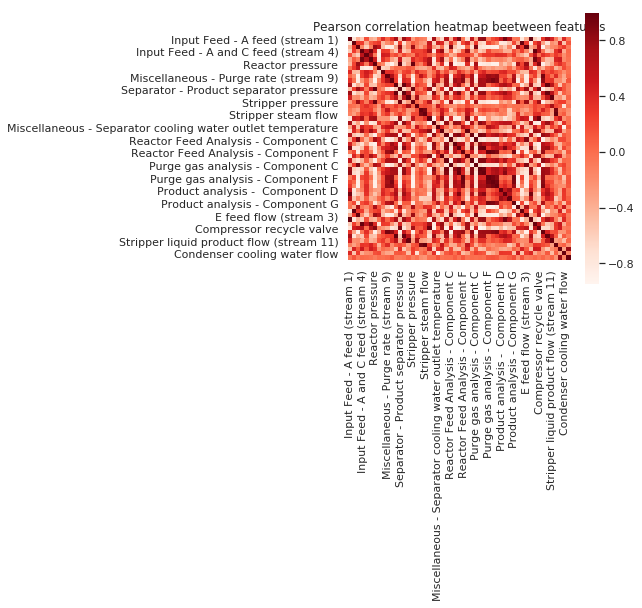

In [12]:
cor = df.corr()
plt.figure(figsize=(5, 5))
# Plot Pearson correlation heatmap beetween features
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7) ],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7) ],
     'blue': [(0, 0.7, 0.7), (1, 1, 1) ]})
plt.cm.register_cmap(cmap=cmap)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds, square=True)
plt.title("Pearson correlation heatmap beetween features")
plt.show()

# 5) Look for relevant features analysing the correlation of each feature with output variable.
This is done selecting features highly correlated with output variable (and each other...)
Only weee only select features which has correlation of above 0.2 (absolute value) with
Sthe output variable.

In [0]:
cor_target = abs(cor [ 'Process Faults' ])
relevant_features = cor_target [ cor_target > 0.20 ]
print(relevant_features)

Stripper steam flow           0.235474
Stripper steam valve          0.228979
Reactor cooling water flow    0.794822
Process Faults                1.000000
Name: Process Faults, dtype: float64


As we can see, only the features ***"Stripper steam flow"***, ***"Stripper steam valve"*** and ***"Reactor cooling water flow"*** are
highly correlated with the output variable ***"Process Faults"***. Hence we will drop all other features apart from these dataset.

However this is not the end of the process. One good assumption at this point is that the independent variables need to be uncorrelated with each other.

If these variables are correlated with each other, then we need to keep only one of them and drop the rest.

So let us check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix or from the code snippet below:  


In [0]:
print("CHECK CORRELATION BETWEEN FEATURES")
print("\n",df [ [ "Stripper steam flow", "Stripper steam valve" ] ].corr())
print("\n",df [ [ "Reactor cooling water flow", "Stripper steam valve" ] ].corr())
print("\n",df [ [ "Reactor cooling water flow", "Stripper steam flow" ] ].corr())


CHECK CORRELATION BETWEEN FEATURES

                       Stripper steam flow  Stripper steam valve
Stripper steam flow              1.000000              0.995273
Stripper steam valve             0.995273              1.000000

                             Reactor cooling water flow  Stripper steam valve
Reactor cooling water flow                    1.000000             -0.033502
Stripper steam valve                         -0.033502              1.000000

                             Reactor cooling water flow  Stripper steam flow
Reactor cooling water flow                    1.000000            -0.018407
Stripper steam flow                          -0.018407             1.000000


From the above result, it is seen that the variables ***"Stripper steam flow"*** and ***"Stripper steam valve"*** are highly correlated with each other (**0.995273**). Hence we would keep only one variable and drop the other.

We will keep ***"Stripper steam flow"*** since its correlation with the output ***"Process faults"*** is higher.

Besides, the feature **"Stripper steam flow"** is either less correlated with ***"Reactor cooling water flow"***

So, finally, after dropping ***"Stripper steam valve"***, we are left with only two feature:
* "Reactor cooling water flow"
* "Stripper steam flow"

These are the final features given by Pearson correlation


In [0]:
X_reduced = df [ [ "Reactor cooling water flow", "Stripper steam flow" ] ]
X_reduced = StandardScaler().fit_transform(X_reduced)


# 6) Print Results of classifiers comparisson with the selected features above
Here we print the classification results using only the 2 selected features:
*  ***"Reactor cooling water flow"***
* ***"Stripper steam valve"***


In [0]:
for name, clf in zip(classifiers_names, classifiers):
    print("\n <<< Classification with ",name," with ONLY 2 SELECTED FEATURES>>>")
    y_pred_overall, y_test_overall = classify_with_stratified_kfold(clf, X_reduced, y, kf)
    print_report(y_test=y_test_overall, y_pred=y_pred_overall,
                 target_names=[ 'Normal', 'Input Feed - E feed (stream 3)' ], labels=np.unique(y))


 <<< Classification with  QDA  with ONLY 2 SELECTED FEATURES>>>
                                precision    recall  f1-score   support

                        Normal      0.998     1.000     0.999       833
Input Feed - E feed (stream 3)      1.000     0.993     0.996       278

                     micro avg      0.998     0.998     0.998      1111
                     macro avg      0.999     0.996     0.998      1111
                  weighted avg      0.998     0.998     0.998      1111

 Accuracy  =  99.82 %
 F-measure =  99.76 %
 Precision =  99.88 %
 Recall    =  99.64 %
 Confusion matrix =
 [[833   0]
 [  2 276]]

 <<< Classification with  Nearest Neighbors  with ONLY 2 SELECTED FEATURES>>>
                                precision    recall  f1-score   support

                        Normal      0.999     1.000     0.999       833
Input Feed - E feed (stream 3)      1.000     0.996     0.998       278

                     micro avg      0.999     0.999     0.999      1111

# 7) Plot bounderies of classifiers with the selected features

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


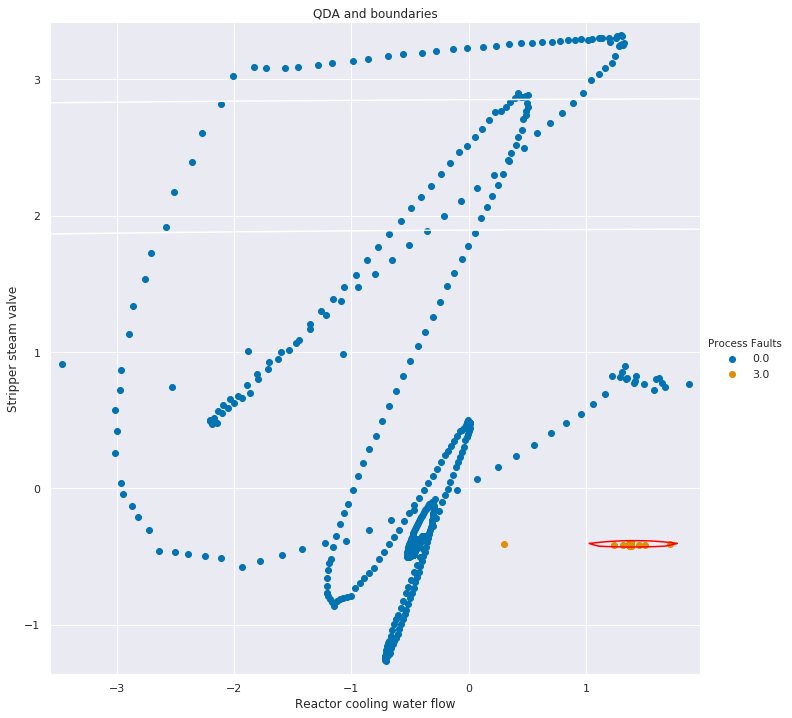

In [0]:
#figure = plt.figure(figsize=(27, 9))
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=.4, random_state=42)
x_min, x_max = X_reduced[:, 0].min() - .1,\
               X_reduced[:, 0].max() + .1
y_min, y_max = X_reduced[:, 1].min() - .1,\
               X_reduced[:, 1].max() + .1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
df_reduced = pd.DataFrame(np.concatenate((X_reduced, y.reshape(-1, 1)), axis=1))
df_reduced.columns = [ "Reactor cooling water flow", "Stripper steam valve", "Process Faults" ]
# QDA
g = sns.FacetGrid(df_reduced, hue="Process Faults", size=10, palette='colorblind').map(plt.scatter, "Reactor cooling water flow",
                                                                                       "Stripper steam valve", ).add_legend()
my_ax = g.ax
clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(X=X_train, y=y_train)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
zz = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Reshaping the predicted class into the meshgrid shape
Z = zz.reshape(xx.shape)
# Plot the filled and boundary contours
my_ax.contour(xx, yy, Z, 2, alpha=1, colors=('red', 'white', 'white'))
# Addd axis and title
my_ax.set_xlabel("Reactor cooling water flow")
my_ax.set_ylabel("Stripper steam valve")
my_ax.set_title("QDA and boundaries")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


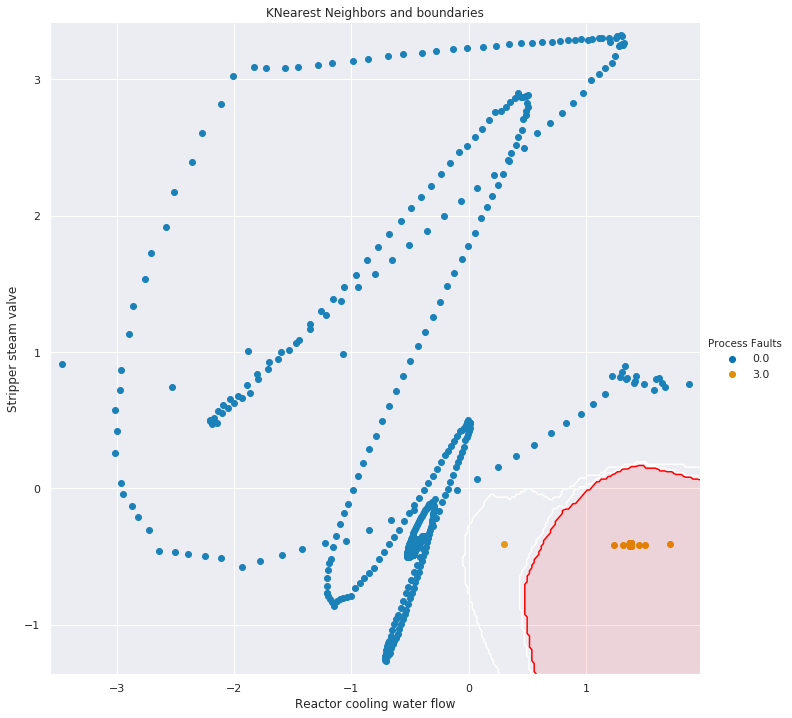

In [0]:
# KNN
    g = sns.FacetGrid(df_reduced, hue="Process Faults", size=10, palette='colorblind').map(plt.scatter, "Reactor cooling water flow",
                                                                                           "Stripper steam valve", ).add_legend()
    my_ax = g.ax
    clf = KNeighborsClassifier(3)
    clf.fit(X=X_train, y=y_train)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    zz = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Reshaping the predicted class into the meshgrid shape
    Z = zz.reshape(xx.shape)
    # Plot the filled and boundary contours
    my_ax.contourf(xx, yy, Z, 2, alpha=.1, colors=('white', 'white', 'red'))
    my_ax.contour(xx, yy, Z, 2, alpha=1, colors=('white', 'white', 'red'))
    # Addd axis and title
    my_ax.set_xlabel("Reactor cooling water flow")
    my_ax.set_ylabel("Stripper steam valve")
    my_ax.set_title("KNearest Neighbors and boundaries")
    plt.show()
